In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split

%matplotlib inline

pd.options.display.max_rows = 20

In [2]:
df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')

In [3]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,201903,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Enplaned,Other,International,A,6995
1,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Enplaned,Other,International,A,12172
2,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Deplaned,Other,International,A,11496
3,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Enplaned,Other,International,G,7473
4,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Deplaned,Other,International,G,6857


In [4]:
df.groupby('Terminal').sum()['Passenger Count']

Terminal
International    162754209
Other                  200
Terminal 1       139649684
Terminal 2        61338607
Terminal 3       242822759
Name: Passenger Count, dtype: int64

In [5]:
df.shape

(20256, 12)

In [6]:
# Dropping nulls that I found in columns - only a few
df.dropna(inplace = True)

In [7]:
df.columns

Index(['Activity Period', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count'],
      dtype='object')

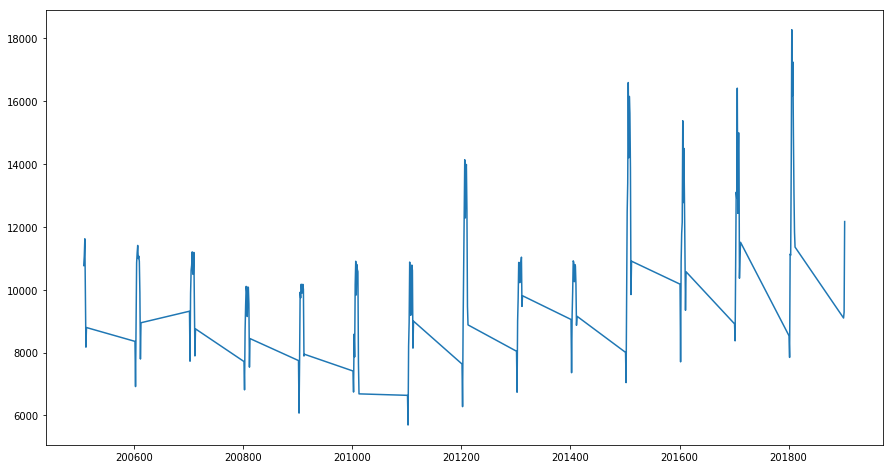

In [8]:
# Plotting one airline's flights against time to see how the time series look

df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic')  & (df['Activity Type Code'] == 'Enplaned')]

# Plot of passengers leaving SFO on Virgin Atlantic
plt.figure(figsize = (15,8))
plt.plot(df_explore_virgin['Activity Period'], df_explore_virgin['Passenger Count']);

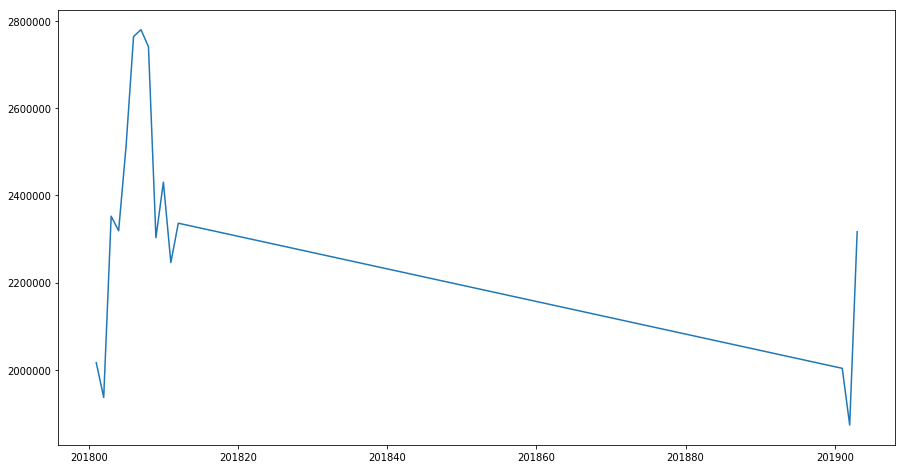

In [9]:
df_explore = df[df['Activity Type Code'] == 'Enplaned'].groupby('Activity Period').sum()

df_explore = df_explore[df_explore.index >= 201800]

# Zoomed-in version shows that it is interpreting the difference between "201812" and "201901" incorrectly
plt.figure(figsize = (15,8))
plt.plot(df_explore.index, df_explore['Passenger Count']);

# Data Cleaning

In [10]:
df['date'] = pd.to_datetime(df['Activity Period'], format = '%Y%m')

In [11]:
# Eliminating rows that account for passengers in layovers. Don't care about those
df.set_index('Activity Type Code', inplace = True)
df.drop(index = 'Thru / Transit', inplace = True)

In [12]:
# Changing the index to dates so that I can use time-series unique functions like pd.resample()
df.reset_index(inplace = True)

# Dropping the no longer useful column that we derived dates from
df.drop(columns = 'Activity Period', inplace = True)

In [13]:
# Cleaning up the name of the 'United Airlines' that is pre-2013
df.replace('United Airlines - Pre 07/01/2013', 'United Airlines', inplace = True)

## Next up: I need to group by the proper types so I can get "enplaned" and "deplaned" trends, and conduct separate time series analysis on them

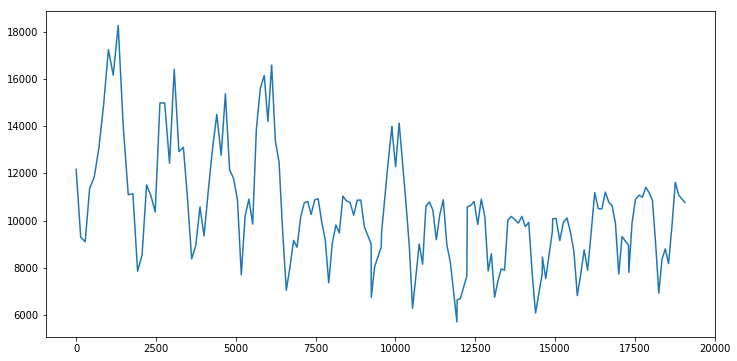

In [14]:
df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic')  & (df['Activity Type Code'] == 'Enplaned')]

# Improved plot of Virgin Atlantic after datetime was fixed
plt.figure(figsize = (12,6))
plt.plot(df_explore_virgin.index, df_explore_virgin['Passenger Count']);

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


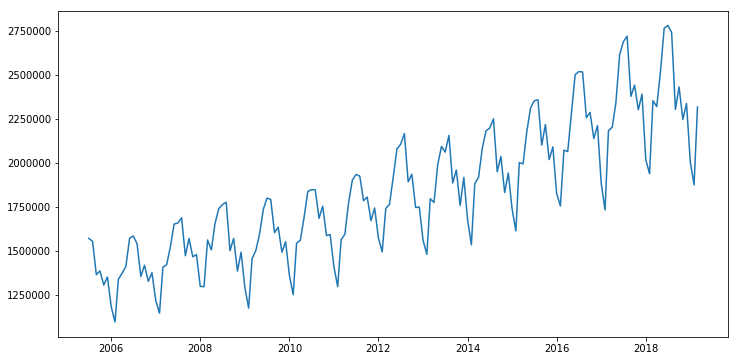

In [15]:
enplaned = df[df['Activity Type Code'] == 'Enplaned'].groupby('date').sum()

# Improved plot of total air traffic after datetime was fixed

plt.figure(figsize = (12,6))
plt.plot(enplaned.index, enplaned['Passenger Count']);

### I will choose to not use moving averages for the above, since my data is on the month level, I do not want to smooth further than the level of the month

I might need to use multiplicative seasonality in this case, since the amplitude of the seasonal trends is increasing with the increase in number of passengers

## Operating Airline vs Published Airline

In [16]:
# A company like SkyWest Airline is never a Published Airline - only an Operating Airline
df.loc[df['Operating Airline'] == 'SkyWest Airlines', 'Published Airline'].unique()

array(['United Airlines', 'Alaska Airlines', 'Delta Air Lines',
       'American Airlines'], dtype=object)

In [17]:
df['Operating Airline'].value_counts()

United Airlines                     3295
SkyWest Airlines                    1292
Alaska Airlines                      820
Virgin America                       462
Delta Air Lines                      446
Air Canada                           438
American Airlines                    416
JetBlue Airways                      337
Sun Country Airlines                 335
Frontier Airlines                    332
                                    ... 
Jet Airways                           16
Miami Air International               16
Allegiant Air                         16
Air Canada Jazz                       14
Independence Air                      10
World Airways                          3
Norwegian Air UK Ltd                   2
Evergreen International Airlines       2
Xtra Airways                           2
Atlas Air, Inc                         1
Name: Operating Airline, Length: 84, dtype: int64

In [18]:
df['Published Airline'].value_counts()

United Airlines                     4182
Alaska Airlines                     1178
Delta Air Lines                      990
American Airlines                    660
Air Canada                           520
Virgin America                       462
US Airways                           407
JetBlue Airways                      337
Sun Country Airlines                 335
Frontier Airlines                    332
                                    ... 
Icelandair EHF                        20
Jet Airways                           16
Miami Air International               16
Allegiant Air                         16
Independence Air                      10
World Airways                          3
Xtra Airways                           2
Norwegian Air UK Ltd                   2
Evergreen International Airlines       2
Atlas Air, Inc                         1
Name: Published Airline, Length: 74, dtype: int64

In [19]:
# Shows that Operating Airline is different from Published Airline ~2000 times: 1/10 of the time in my df
df[df['Operating Airline'] != df['Published Airline']]

,Activity Type Code,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Price Category Code,Terminal,Boarding Area,Passenger Count,date
39,Enplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,Terminal 3,F,3363,2019-03-01
40,Deplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,Terminal 3,F,3262,2019-03-01
41,Deplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,International,G,3191,2019-03-01
42,Enplaned,SkyWest Airlines,OO,United Airlines,UA,Domestic,US,Other,Terminal 3,F,167195,2019-03-01
43,Deplaned,SkyWest Airlines,OO,United Airlines,UA,Domestic,US,Other,Terminal 3,F,172593,2019-03-01
44,Enplaned,SkyWest Airlines,OO,Alaska Airlines,AS,Domestic,US,Other,Terminal 2,D,18534,2019-03-01
45,Deplaned,SkyWest Airlines,OO,Alaska Airlines,AS,Domestic,US,Other,Terminal 2,D,18142,2019-03-01
46,Enplaned,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Other,Terminal 1,C,8263,2019-03-01
47,Deplaned,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Other,Terminal 1,C,8496,2019-03-01
68,Enplaned,Jazz Aviation,QK,Air Canada,AC,International,Canada,Other,International,G,7719,2019-03-01


**I will use Operating Airlines since that indicates who is actually flying the flight. The Published Airline is the one who is marketing the flight, and Operating is the one who is actually flying it. Individuals know that the flight is being operated by SkyWest Airlines, for instance, even if they bought the ticket from United.**

In [20]:
# Autocorrelation across all airlines is very close to 1
enplaned['Passenger Count'].autocorr(lag = 12)

0.9827490118965926

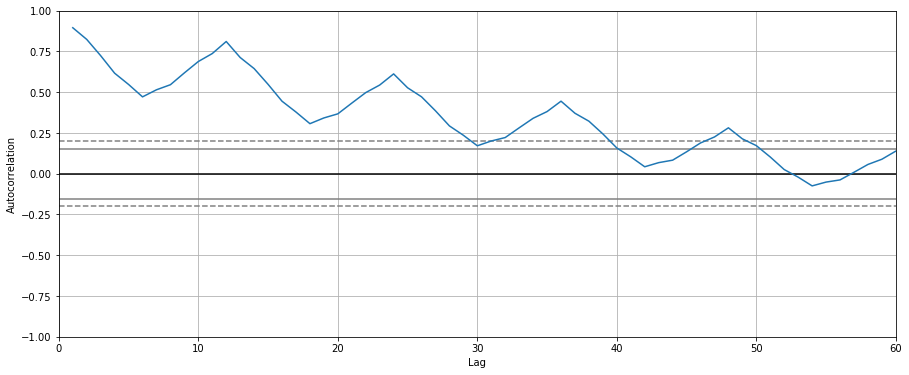

In [21]:
# We definitely have autocorrelation - peaking at the 12 month mark and the 1 month mark
plt.figure(figsize = (15,6))
pd.plotting.autocorrelation_plot(enplaned['Passenger Count'])
plt.xlim(0,60);

## Differencing

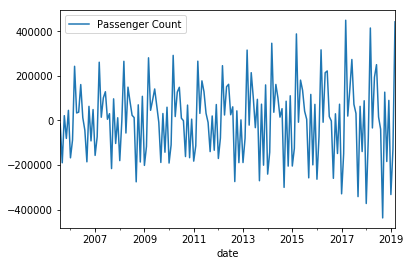

In [22]:
enplaned.diff().dropna().plot();

## Check for stationarity

Aiming for an autocorrelation that is approximately 0, and not more negative that -0.5, per https://people.duke.edu/~rnau/411arim2.htm

In [23]:
print(enplaned['Passenger Count'].autocorr())
print(enplaned['Passenger Count'].diff().autocorr()) # Autocorrelation approx == 0
print(enplaned['Passenger Count'].diff().diff().autocorr())

0.9009954328098658
-0.12716916391020128
-0.6064341398992737


In [24]:
print(enplaned.std())
print(enplaned.diff().std()) # Std is at its lowest
print(enplaned.diff().diff().std())

Passenger Count    380995.515031
dtype: float64
Passenger Count    169512.571295
dtype: float64
Passenger Count    252641.798598
dtype: float64


Both of the above tests confirm that only one layer of differencing is needed in our model

## Decomposition

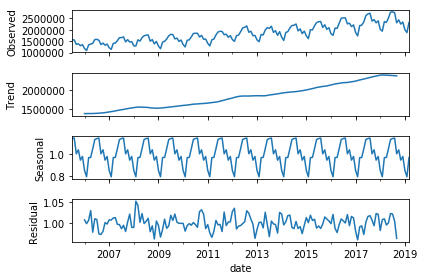

In [25]:
# From statsmodels package - generates a seasonal decomposition automatically
seasonal_decompose(enplaned, model = 'multiplicative').plot();

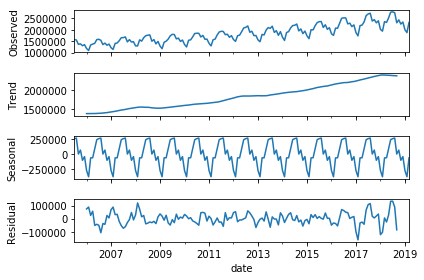

In [26]:
# Looks like an additive model is about the same, without the complications of a multiplicative model, even though
# the first level of differencing above makes it look like I should use a multiplicative model
seasonal_decompose(enplaned, model = 'additive').plot();

### ARIMA guides for further work, if needed:

Textbooks:

https://people.duke.edu/~rnau/seasarim.htm

http://www.statsoft.com/Textbook/Time-Series-Analysis#1general

Articles:

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

Documentation examples:

https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

In [27]:
df.head()

,Activity Type Code,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Price Category Code,Terminal,Boarding Area,Passenger Count,date
0,Enplaned,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Other,International,A,6995,2019-03-01
1,Enplaned,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Other,International,A,12172,2019-03-01
2,Deplaned,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Other,International,A,11496,2019-03-01
3,Enplaned,United Airlines,UA,United Airlines,UA,International,Middle East,Other,International,G,7473,2019-03-01
4,Deplaned,United Airlines,UA,United Airlines,UA,International,Middle East,Other,International,G,6857,2019-03-01


In [28]:
df_enplaned = df[df['Activity Type Code'] == 'Enplaned']
df_deplaned = df[df['Activity Type Code'] == 'Deplaned']

df_enplaned = df_enplaned.groupby(by = ['date', 'Operating Airline']).sum()
df_deplaned = df_deplaned.groupby(by = ['date', 'Operating Airline']).sum()

In [29]:
df_deplaned

Passenger Count
date       Operating Airline                       
2005-07-01 ATA Airlines                       27271
           Air Canada                         35156
           Air China                           6263
           Air France                         12050
           Air New Zealand                     4998
           AirTran Airways                     8055
           Alaska Airlines                    51587
           All Nippon Airways                  6545
           American Airlines                 166577
           American Eagle Airlines             5493
...                                             ...
2019-03-01 SAS Airlines                        6613
           Singapore Airlines                 15160
           SkyWest Airlines                  205684
           Southwest Airlines                134267
           Sun Country Airlines                4007
           Swiss International                 8549
           TACA                                6923
           Turkish Airlines                    9674
           United Airlines                   870014
           Virgin Atlantic                    11496

[6854 rows x 1 columns]

In [30]:
df_grouped = df_enplaned.merge(df_deplaned,
                               left_index = True,
                               right_index = True,
                               how = 'left',
                               suffixes = (' Enplaned', ' Deplaned'))

In [31]:
# Why the small difference between the merged and original values?
# Difference is so small, it's probably not worth investigating. Couldn't find a 1550 passenger row
print(df_grouped['Passenger Count Enplaned'].sum(), df_enplaned['Passenger Count'].sum())
print(df_grouped['Passenger Count Deplaned'].sum(), df_deplaned['Passenger Count'].sum())
print(df_grouped['Passenger Count Deplaned'].sum() - df_deplaned['Passenger Count'].sum())

302023123 302023123
303087086.0 303088636
-1550.0


In [41]:
df_grouped['Passenger Count Difference'] = df_grouped['Passenger Count Deplaned'] - \
                                           df_grouped['Passenger Count Enplaned']

df_grouped['Passenger Count %'] = df_grouped['Passenger Count Deplaned'] / \
                                  df_grouped['Passenger Count Enplaned'] * 100

df_grouped

,date,Operating Airline,Passenger Count Enplaned,Passenger Count Deplaned,Passenger Count Difference,Passenger Count %
0,2005-07-01,ATA Airlines,29131,27271.0,-1860.0,93.615049
1,2005-07-01,Air Canada,34090,35156.0,1066.0,103.127017
2,2005-07-01,Air China,5500,6263.0,763.0,113.872727
3,2005-07-01,Air France,11638,12050.0,412.0,103.540127
4,2005-07-01,Air New Zealand,4962,4998.0,36.0,100.725514
5,2005-07-01,AirTran Airways,7984,8055.0,71.0,100.889279
6,2005-07-01,Alaska Airlines,58262,51587.0,-6675.0,88.543133
7,2005-07-01,All Nippon Airways,6094,6545.0,451.0,107.400722
8,2005-07-01,American Airlines,160890,166577.0,5687.0,103.534713
9,2005-07-01,American Eagle Airlines,5213,5493.0,280.0,105.371187


In [33]:
df_grouped.reset_index(inplace = True)

In [48]:
total_enplaned = df_grouped.groupby('Operating Airline').sum()['Passenger Count Enplaned'].sort_values()

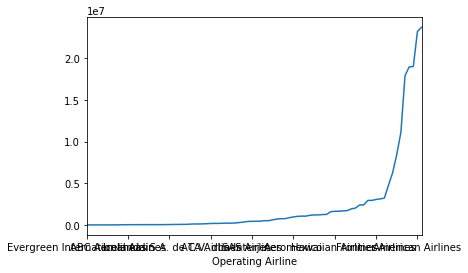

In [69]:
# Cutoff seems to be around 250,000 total passengers, for major airlines
total_enplaned[:-1].plot();

In [56]:
# Can see the most important airways
list(zip(total_enplaned.index, list(total_enplaned)))

[('Evergreen International Airlines', 2),
 ('Ameriflight', 72),
 ('Xtra Airways', 73),
 ('Norwegian Air UK Ltd', 330),
 ('World Airways', 530),
 ('Miami Air International', 733),
 ('Air Canada Jazz', 1985),
 ('BelAir Airlines', 4821),
 ('Allegiant Air', 12090),
 ('Atlantic Southeast Airlines', 25641),
 ('Icelandair', 26860),
 ('Iberia', 28392),
 ('Finnair', 28866),
 ('Republic Airlines', 29726),
 ('Thomas Cook Airlines', 31573),
 ('Icelandair EHF', 31679),
 ('Jet Airways', 32077),
 ('French Bee', 32277),
 ('Independence Air', 32556),
 ('Spirit Airlines', 37172),
 ('ABC Aerolineas S.A. de C.V. dba Interjet', 44184),
 ('Air Pacific Limited dba Fiji Airways', 53146),
 ('Hong Kong Airlines Limited', 55994),
 ('Mesaba Airlines', 63428),
 ('XL Airways France', 67001),
 ('ExpressJet Airlines', 93456),
 ('Volaris Airlines', 113438),
 ('Air Berlin', 113644),
 ('LAN Peru', 125095),
 ('Jazz Aviation', 142716),
 ('ATA Airlines', 175794),
 ('WOW Air', 179677),
 ('Etihad Airways', 182806),
 ('Americ

In [65]:
# Finds the names of the top 15 airlines by quantity of passengers leaving SFO

top15_list = list(df_grouped.groupby('Operating Airline').
                  sum().
                  sort_values('Passenger Count Enplaned', ascending = False)[:15].
                  index)

In [66]:
top15_list

['United Airlines',
 'SkyWest Airlines',
 'American Airlines',
 'Virgin America',
 'Delta Air Lines',
 'Southwest Airlines',
 'Alaska Airlines',
 'US Airways',
 'JetBlue Airways',
 'Air Canada',
 'Lufthansa German Airlines',
 'Northwest Airlines',
 'Frontier Airlines',
 'Cathay Pacific',
 'British Airways']

# Time Series (full airport's arrivals)

In [83]:
dp_airport = df_deplaned.groupby('date').sum()

### Train/Test Split

In [103]:
train = dp_airport.loc[dp_airport.index.year <= 2014, 'Passenger Count']
validation = dp_airport.loc[(dp_airport.index.year >= 2015) & (dp_airport.index.year <= 2016), 'Passenger Count']
test = dp_airport.loc[dp_airport.index.year >= 2017, 'Passenger Count']

### Data Visualization, pre-SARIMA

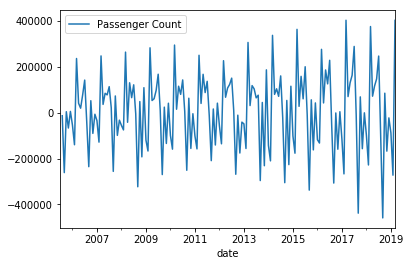

In [89]:
dp_airport.diff().plot();

In [88]:
# 1 diff seems to work really well for this data
dp_airport.diff()['Passenger Count'].autocorr()

-0.07974577331389328

In [105]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

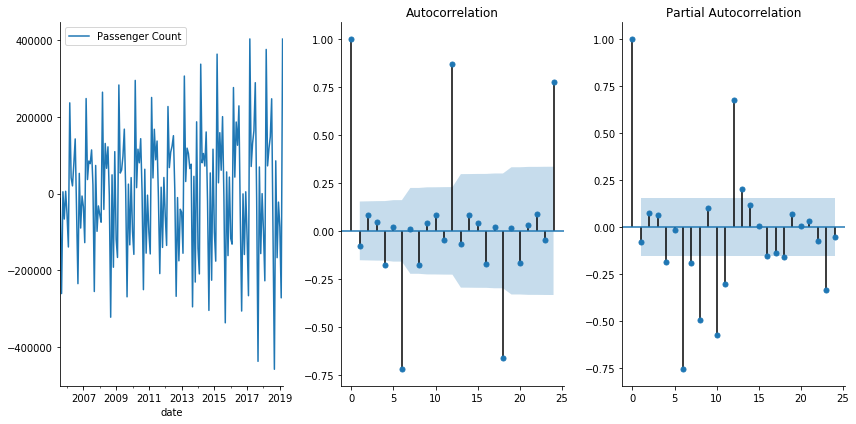

In [119]:
# ACF and PACF plots look the same from all different starting point months
plots(dp_airport.diff()[1:], lags=24);

## Build SARIMA pipeline

In [132]:
# Test cell to see how 1 SARIMA works
sar = SARIMAX(train, order=(1,1,0), seasonal_order=(1,1,0,12), trend='t').fit()
sar.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    Passenger Count   No. Observations:                  114
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1238.809
Date:                            Mon, 10 Jun 2019   AIC                           2485.618
Time:                                    20:28:54   BIC                           2496.078
Sample:                                07-01-2005   HQIC                          2489.853
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -12.8237     58.980     -0.217      0.828    -128.422     102.774
ar.L1         -0.0234      0.025     -0.942      0.346      -0.072       0.025
ar.S.L12      -0.0255      0.023     -1.119      0.263      -0.070       0.019
sigma2      2.339e+09   8.07e-06    2.9e+14      0.000    2.34e+09    2.34e+09
===================================================================================
Ljung-Box (Q):                       86.97   Jarque-Bera (JB):                40.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.82
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.24e+29. Standard errors may be unstable.
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


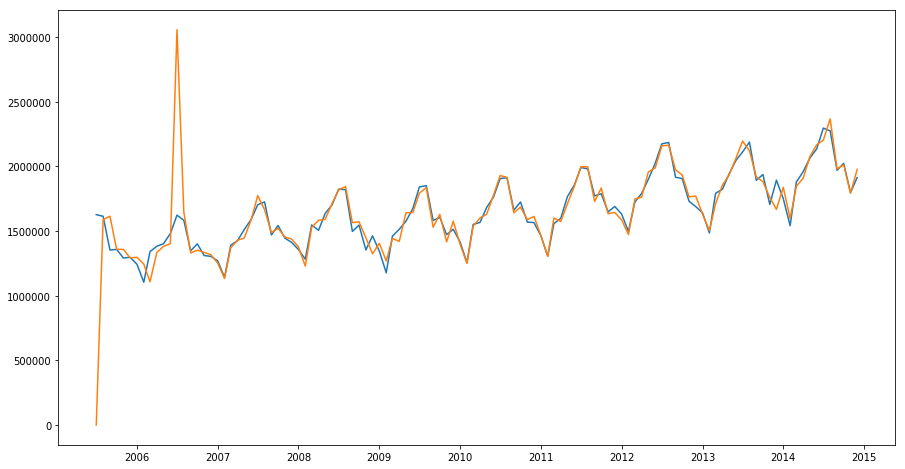

In [143]:
sar = SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,1,12), trend='t').fit()

plt.figure(figsize = (15,8))
plt.plot(train)
plt.plot(sar.predict());

In [158]:
# Grid Searching my way to the ideal SARIMA model

# Assumption: 1 order of differencing is best for my model
residuals = {}

for p in range(3):
    for q in range(3):
        for P in range(3):
            for D in range(2):
                for Q in range(3):
                    for t in ['c','t']:
                        sar = SARIMAX(train, order=(p,1,q), seasonal_order=(P,D,Q,12), trend=t,
                                      enforce_stationarity=False, enforce_invertibility=False).fit()

                        residuals[f"SARIMA({p},1,{q})({P},{D},{Q},12), {t} trend"] = abs(sar.resid).sum()
                    #residuals.append(abs(sar.resid).sum())
                    

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/an

In [160]:
min(residuals)

'SARIMA(0,1,0)(0,0,0,12), c trend'

In [162]:
min(residuals, key = residuals.get)

'SARIMA(0,1,0)(2,0,2,12), c trend'

In [163]:
residuals['SARIMA(0,1,0)(2,0,2,12), c trend']

7033050.710699014

In [170]:
sar.predict(validation)

TypeError: Cannot convert input [date
2015-01-01    1812521
2015-02-01    1636133
2015-03-01    1999996
2015-04-01    2028066
2015-05-01    2186927
2015-06-01    2247789
2015-07-01    2448567
2015-08-01    2438908
2015-09-01    2101544
2015-10-01    2158013
               ...   
2016-03-01    2066432
2016-04-01    2109355
2016-05-01    2296057
2016-06-01    2422088
2016-07-01    2650944
2016-08-01    2593874
2016-09-01    2287271
2016-10-01    2286462
2016-11-01    2127437
2016-12-01    2132062
Name: Passenger Count, Length: 24, dtype: int64] of type <class 'pandas.core.series.Series'> to Timestamp

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


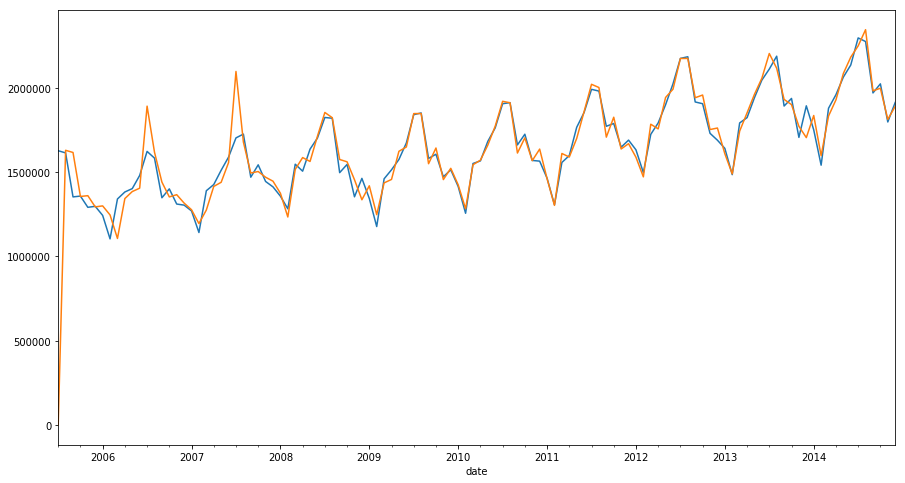

In [169]:
best_sarima = SARIMAX(train, order=(0,1,0), seasonal_order=(2,0,2,12), trend='c',
                      enforce_stationarity=False, enforce_invertibility=False).fit()

plt.figure(figsize=(15,8))
train.plot()
best_sarima.predict().plot();

In [ ]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time series on Passenger Difference (for each of 15 airlines - to predict)

Here I am predicting the seasonality of the difference in passengers coming in and out of SFO (not the seasonality of departures or arrivals themselves).

This prediction could be useful for the airlines themselves (sales forecasting) or for consumers (general ideas of which airlines are the least busy - if you want cheap tickets or to fly on planes that have less passengers, and more overhead baggage space).

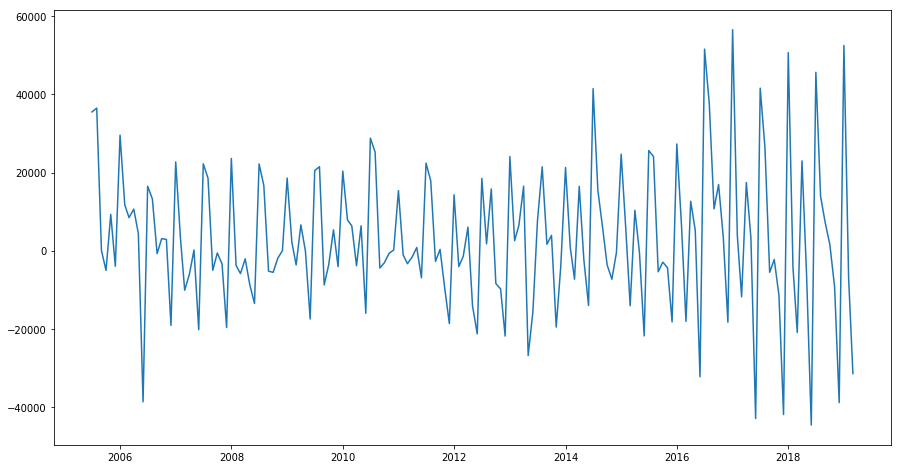

In [38]:
plt.figure(figsize = (15,8))
plt.plot(df_grouped.loc[df_grouped['Operating Airline'] == 'United Airlines', 'date'],
         df_grouped.loc[df_grouped['Operating Airline'] == 'United Airlines', 'Passenger Count Difference']);

## Old EDA - to be deleted if not used

In [39]:
df_test = df_enplaned.merge(df_deplaned,
                  on = list(df_deplaned.drop(columns = ['Passenger Count', 'Activity Type Code'])),
                  how = 'left',
                  suffixes = (' Enplaned', ' Deplaned'))

KeyError: "['Activity Type Code'] not found in axis"

In [ ]:
df_test[df_test['Passenger Count Deplaned'].isna()]

In [ ]:
df_test_reverse[df_test_reverse['Passenger Count Deplaned'].isna()]

In [ ]:
df_test_reverse = df_deplaned.merge(df_enplaned,
                  on = list(df_enplaned.drop(columns = ['Passenger Count', 'Activity Type Code'])),
                  how = 'left',
                  suffixes = (' Enplaned', ' Deplaned'))

In [ ]:
print(df_test_reverse.shape, df_test.shape)

In [ ]:
# The amounts are not equal, when they should be
print(df_deplaned['Passenger Count'].sum(), df_test['Passenger Count Deplaned'].sum())

In [ ]:
# # Doing a self-join with outgoing passengers 
# df.merge(df.loc[df['Activity Type Code'] == 'Deplaned', 'Passenger Count'],
#          on = df.drop(columns = 'Activity Type Code').columns,
#          )